# Машинное обучение, DS-поток, осень 2024

## Задание ML.10


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Баллы за задание**  
Задача 1. &mdash; **200 баллов**  

Всего &mdash; **200 баллов**  

In [27]:
# Bot check

# HW_ID: ds_ml10
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [28]:
# !pip install captum[visualization]
!pip install --upgrade captum


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
import time
import numpy as np
from collections import defaultdict

import seaborn as sns
sns.set(palette='Set2')
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
import torchvision
from torchvision import transforms
from captum.attr import Occlusion
# import captum.visualization as viz

### Задача 1. Исследование свойств сверток

#### 1. Данные

Обратимся к датасету CIFAR10. Скачаем тренировочную и тестовую части данных.

In [30]:
# Часть данных для обучения
train_dataset = torchvision.datasets.CIFAR10(root='./cifar', download=True, train=True, transform=transforms.ToTensor())
# Валидационная / тестовая часть данных
val_dataset = torchvision.datasets.CIFAR10(root='./cifar', download=True, train=False, transform=transforms.ToTensor())
# Классы объектов в датасете
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [06:31<00:00, 435306.62it/s] 


Extracting ./cifar\cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


Проверим размеры датасета.

In [31]:
len(train_dataset), len(val_dataset)

(50000, 10000)

Иллюстрируем 2 примера изображений.

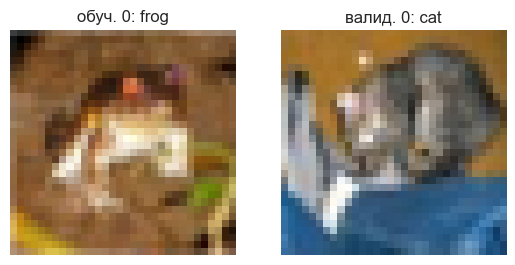

In [32]:
train_idx, val_idx = 0, 0

plt.subplot(1, 2, 1)
plt.imshow(train_dataset[train_idx][0].permute(1, 2, 0))
plt.title(f'обуч. {train_idx}: {classes[train_dataset[train_idx][1]]}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(val_dataset[val_idx][0].permute(1, 2, 0))
plt.title(f'валид. {val_idx}: {classes[val_dataset[val_idx][1]]}')
plt.axis('off')

plt.show()

In [33]:
val_dataset[val_idx][0].shape

torch.Size([3, 32, 32])

#### 2. Различия между свертками

Постройте модель состоящую из 3 сверточных слоев с параметрами `kernel_size=3` и `stride=1` по правилу
$$INPUT \to [CONV \to RELU]^3 \to POOL \to FC \to RELU \to FC,$$

Также можно пользоваться `Dropout` и `BatchNorm`.
Пример аналогичного построения см. в семинаре.

In [34]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1),
    nn.BatchNorm2d(32),
    nn.Dropout(0.3),
    nn.ReLU(),

    nn.Conv2d(32, 64, kernel_size=3, stride=1),
    nn.BatchNorm2d(64),
    nn.Dropout(0.3),
    nn.ReLU(),

    nn.Conv2d(64, 64, kernel_size=3, stride=1),
    nn.BatchNorm2d(64),
    nn.Dropout(0.3),
    nn.ReLU(),

    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(2304, 512),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(512, 10)
)

Выполните следующие действия.
1. Посчитайте общее количество параметров сети и количество параметров в сверточных слоях.
2. Обучите ее на тренировочной части данных и сохраните веса обученной модели.
3. Посчитайте среднее время одного прямого прохода (forward pass) и среднее время обратного прохода (backward pass) по сети во время обучения.
4. Сохраните историю изменения ошибки (loss) и точности (accuracy) во время обучения.


Посчитайте область видимости (receptive filed) нейронов последней свертки. Какую область картинки видит нейрон последнего слоя свертки?

**Ответ:** <...>

Проведем эксперимент для сравнения работы различных сверток. Для этого постройте еще три модели, которые должны следовать перечисленным ниже требованиям.

Во-первых, необходимо сделать такие модели, у которых область видимости (receptive field) последнего сверточного слоя такая же как у модели построенной ранее. Тогда мы будем ожидать у моделей схожую обобщающую способность.

Во-вторых, установим ограничение на количество каналов в свертках. Оно нужно для корректной оценки параметров и скорости работы сети. Пусть $с_{k,in}$ и $c_{k, out}$ &mdash; количество каналов на входе и на выходе свертки на слое $k$ модели. Тогда сумма $\sum_{k} с_{k,in} c_{k, out}$ должна быть одинаковой для всех моделей, т.е. для исходной и трех новых моделей. Для того, чтобы добиться такого результата, можно дополнительно использовать свертки с `kernel_size=1`. При сравнении моделей в выводе поясните необходимость данного требования.

Наконец, т.к. мы хотим рассмотреть работу различных сверток, то перечислим особенности каждой модели по порядку.

1. Включает в себя свертку c `kernel_size=7, stride=1`.
2. Включает в себя свертку c `kernel_size=5, stride=1`.
3. Включает себя свертки c `kernel_size=3, stride=2`.

Обучите новые модели с теми же параметрами обучения, что и раньше. Для каждой из них посчитайте все характеристики, которые были посчитаны для исходной модели. Сравните результаты и сделайте выводы.

**Выводы:** <...>

#### 3. Интерпретируемость
В этой части задания вы попробуете еще один способ интерпретации работы сверточных слоев. На лекции и семинаре для того, чтобы показать что нейроны реагируют на отдельные части изображения, использовались выходы сети целиком. Сейчас же вы сможете проверить, есть ли интерпретируемость на уровне сверточных слоев.

1. Выделите 5 изображений лягушек и 5 изображений самолетов из датасета.
2. Выберете одну из четырех обученных моделей.
3. Для каждого изображения посчитайте выходы последнего сверточного слоя модели и найдите максимумы по каналам. Должен получиться квадратный двумерный тензор для каждого изображения. Он показывает на какие области больше всего реагирует сеть для предсказания соотвествующего класса.  
4. Отобразите результат для каждого изображения.
5. Сравните активации для изображений одного класса и различных классов. Сделайте выводы.

**Вывод:** <...>

На семинаре мы реализовали окклюзию самостоятельно, но она реализована и в библиотеке Captum. Выберите другие 2 класса и примените окклюзию к 5 случайным представителям из каждого класса. Пример визуализации в Captum смотрите в семинаре. Что модель считает важным для определения выбранных классов?

#### 4. Выводы
На основе выполненного здания сделайте выводы об особенностях работы сверток.

<...>